In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import random
import os

from sklearn.model_selection import train_test_split

from keras import Input, layers, optimizers
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense,Dropout, LeakyReLU
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.utils import to_categorical

from lib.data.flickr_dataset import FlickrDataset
from lib.data.feature_vector_generator import FeatureVectorGenerator
from lib.data.glove_word_embedding_generator import GloveWordEmbeddingGenerator
from lib.data.generator.data_generator import DataGenerator

from lib.model.model_wrapper import ModelWrapper
from lib.model.metrics import rmse
from lib.model.search.greedy_search_strategy import GreedySearchStrategy
from lib.model.search.beam_search_strategy import BeamSearchStrategy, EndCriteria
from lib.model.attention_layer import AttentionLayer

from lib.utils.word_utils import word_to_index_and_index_to_word
from lib.utils.file_utils import create_directory
from lib.utils.plot_utils import PredictionInspector, show_sample
from lib.utils.array_utils import column
from lib.utils.pickle_utils import save_obj, load_obj
from lib.utils.sequencer import Sequencer

from keras.callbacks                         import ModelCheckpoint
from lib.callback.metric_plotter             import MetricsPlotter
from lib.callback.adam_learning_rate_tracker import AdamLearningRateTracker
from keras.callbacks                         import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
dataset_name='8k'
# dataset_name='30k'

embedding_vector_dim = 300
embedding_token_count = 6
embedding_token_count = 840
embeding_name = f'{embedding_token_count}B.{embedding_vector_dim}d'
word_embedding_path = f'./dataset/glove.{embeding_name}.txt'



dataset_path=f'./dataset/{dataset_name}'
data_path = f'{dataset_path}/data'
images_path = f'{dataset_path}/images'

image_features_path = f'{dataset_path}/img_features.pkl'
descrption_embedding_path = f'{dataset_path}/descrition_embeding.{embeding_name}.pkl'

line_separator = { 
    '8k': r'#[0-9]',
    '30k': r'\| [0-9]\|'
}
weights_path = create_directory(f'weights/{dataset_name}')
weights_file_path_patern = weights_path + '/weights__epoch_{epoch:02d}__loss_{val_loss:.4f}__acc_{val_rmse:.4f}.h5'

In [4]:
dataset = FlickrDataset(
    data_path, 
    images_path,
    desc_prefix='$', 
    desc_postfix='#',
    clean_desc=True,
    separator=line_separator[dataset_name]
)

Max len desc: $ an africanamerican man wear green sweatshirt and blue vest be hold up dollar bill in front of his face while stand on busy sidewalk in front of group of man play instrument #


In [5]:
train_samples, remain_samples = train_test_split(dataset.samples(), test_size=0.16, shuffle=True)
val_samples, test_samples = train_test_split(remain_samples, test_size=0.22, shuffle=True)

print(f'Train: {len(train_samples)}, Val: {len(val_samples)}, Test: {len(test_samples)}')

Train: 6796, Val: 1010, Test: 285


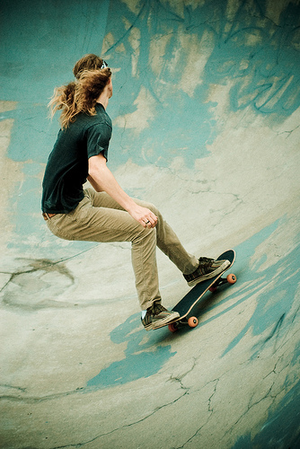

Description
0                      man skateboard
1  person be skateboard in skate hole
2          skateboarder approach ramp
3       skateboarder ride up to slope
4          skateboarder skate in pool

In [6]:
show_sample(train_samples[0])

In [7]:
if not os.path.isfile(image_features_path):
    image_paths = dataset.samples(col=0)
    image_features = list(FeatureVectorGenerator().generate(image_paths))
    save_obj(image_features_path, image_features)

image_features = load_obj(image_features_path)
print(image_features[0])
image_features = dict(image_features)

('./dataset/8k/images/1305564994_00513f9a5b.jpg', array([ 0.06508789,  0.03218704,  0.02376981, ...,  0.38368699,
        0.19910596,  0.23510453], dtype=float32))


In [8]:
min_occurs=10

vocabulary = dataset.words_set(min_occurs=10)
vocabulary_size = len(vocabulary)
complete_vocabulary_size = len(dataset.words_set())
print(f'Words(occurs>={min_occurs}): {vocabulary_size}/{complete_vocabulary_size}')

Words(occurs>=10): 1593/6688


In [9]:
word_to_index, index_to_word = word_to_index_and_index_to_word(vocabulary)

In [10]:
len(word_to_index)

1593

In [11]:
dataset.max_desc_len()

174

In [12]:
if not os.path.isfile(descrption_embedding_path):
    embedding_generator = GloveWordEmbeddingGenerator(word_embedding_path, embedding_vector_dim)
    embedding_matrix = embedding_generator.generate(word_to_index)
    save_obj(descrption_embedding_path, embedding_matrix)

embedding_matrix = load_obj(descrption_embedding_path)
len(embedding_matrix)

1593

In [13]:
def build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, optimizer):
    img_feat_input = Input(name="Image_Feature", shape=(2048,))

    img_branch = Dropout(0.5)(img_feat_input)
    img_branch = Dense(512)(img_branch)
    img_branch = LeakyReLU(alpha=0.3)(img_branch)

    seq_input = Input(name="Description_Sequence", shape=(dataset.max_desc_len(),))

    seq_branch = Embedding(vocabulary_size, embedding_vector_dim, mask_zero=True)(seq_input)
    seq_branch = Dropout(0.5)(seq_branch)
    seq_branch = LSTM(512)(seq_branch)

    decoder = add([img_branch, seq_branch])
    decoder = Dense(512)(decoder)
    decoder = LeakyReLU(alpha=0.3)(decoder)
    
    outputs = Dense(name="Words_Distribution", units=vocabulary_size, activation='softmax')(decoder)

    model = Model(inputs=[img_feat_input, seq_input], outputs=outputs)

    model.layers[3].set_weights([embedding_matrix])
    model.layers[3].trainable = False

    model.compile(
        loss='categorical_crossentropy', 
        optimizer=optimizer,
        metrics=[rmse]
    )

    return ModelWrapper(model)

In [14]:
# 1ª Train:
epochs=10
lr=0.001
batch_size = 12

# 2ª Train:
#epochs=10
#lr=0.0001
#batch_size = 20

steps_per_epoch=len(train_samples)/batch_size

In [15]:
train_generator = DataGenerator(
    train_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

val_generator = DataGenerator(
    val_samples,
    image_features,
    word_to_index,
    index_to_word,
    dataset.max_desc_len(), 
    vocabulary_size,
    batch_size=batch_size
)

In [16]:
callbacks = [
    ModelCheckpoint(
        weights_file_path_patern,
        monitor='val_loss', 
        verbose=1,
        save_best_only=True, 
        save_weights_only=True, 
        mode='auto',
        period=1
    ),
    AdamLearningRateTracker(evaluate_interval=105),
    ReduceLROnPlateau(
        monitor  = 'val_loss',
        factor   = 0.2,
        patience = 1
    ),
    MetricsPlotter(
        val_generator, 
        plot_interval=100, 
        evaluate_interval=100, 
        batch_size=batch_size
    )
]

In [17]:
model = build_model(vocabulary_size, embedding_vector_dim, embedding_matrix, Adam(lr=lr))
# model.show()    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
model.load(f'{weights_path}/weights__epoch_01__loss_2.3339__acc_0.0210.h5')

# model.fit(train_generator, val_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Load weights from weights/8k/weights__epoch_01__loss_2.3339__acc_0.0210.h5


In [38]:
sequencer = Sequencer(
    word_to_index=word_to_index,
    index_to_word=index_to_word,
    max_seq_len=dataset.max_desc_len()
)

search = BeamSearchStrategy(
    model=model,
    sequencer=sequencer,
    seq_prefix='$',
    seq_postfix='#',
    end_criteria=EndCriteria().at_lest_n_end_with(n=5, word='#'),
    k=5
)

def random_sample(samples): return samples[random.randint(0, len(samples)-1)]

inspector = PredictionInspector(search, image_features)

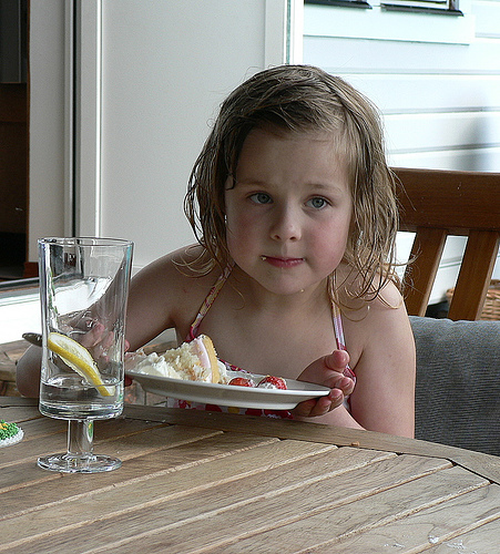

Description
0                    girl wear halter top eat cake at table
1                             little girl hold up her plate
2  little girl be eat cake and strawberries at wooden table
3                           young girl sit at table and eat
4                               little girl be eat outdoors

Predicted description         Score
0  little girl sit at table eat cake  0.1602298512
1            little girl be eat cake  0.2725505695
2           little girl sit at table  0.3418578268

In [39]:
inspector.inspect(random_sample(test_samples))

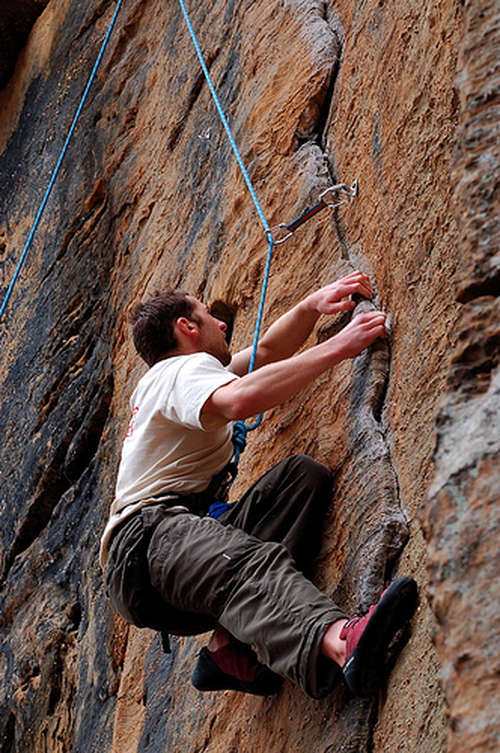

Description
0                                              man climb rock wall
1                                      man climb the side of cliff
2                                                man be rock climb
3               man with red shoe white shirt and gray pants climb
4  young man with white tshirt and jean be rappel up the rock wall

Predicted description         Score
0     man climb rock wall  0.0827932732
1  person climb rock wall  0.1285313782
2     man climb rock face  0.2198252304

In [21]:
inspector.inspect(random_sample(test_samples))

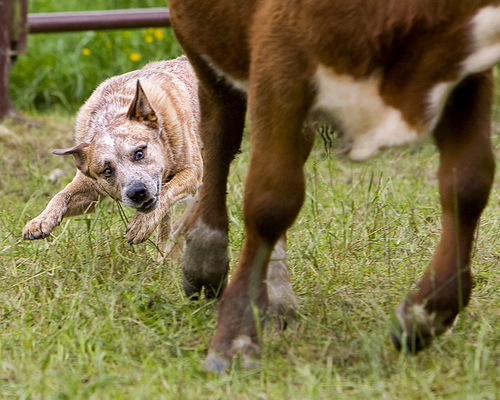

Description
0                           dog nip at the feet of cow
1                              dog pounce on the grass
2                                dog be run after bull
3  large brown dog be play in the grass with brown cow
4                       two dog outside on green grass

Predicted description         Score
0       brown dog be bite each other in the grass  0.0000375505
1  brown dog be play with each other in the grass  0.0000383337
2                    brown dog be bite each other  0.0001516184

In [22]:
inspector.inspect(random_sample(test_samples))

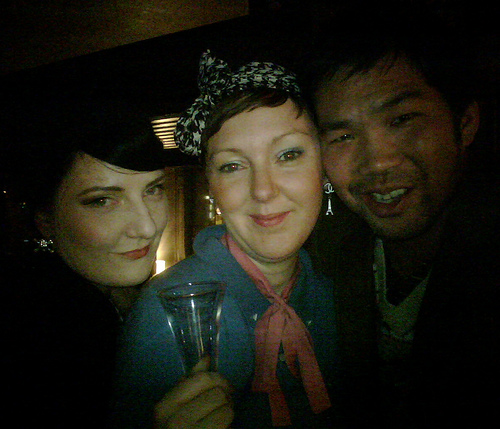

Description
0                                                     closeup of three person smile for the camera
1              girl hold glass and have girl on her right and boy on her left look into the camera
2  girl in black and white headband and pink neck tie hold glass with friend on either side of her
3                                                                    three person pose for picture
4                                                            two woman and man pose for the camera

Predicted description         Score
0      man and woman pose for the camera  0.0113742828
1         man and woman pose for picture  0.0136537694
2  man and woman pose for the camera  of  0.0217228693

In [23]:
inspector.inspect(random_sample(test_samples))

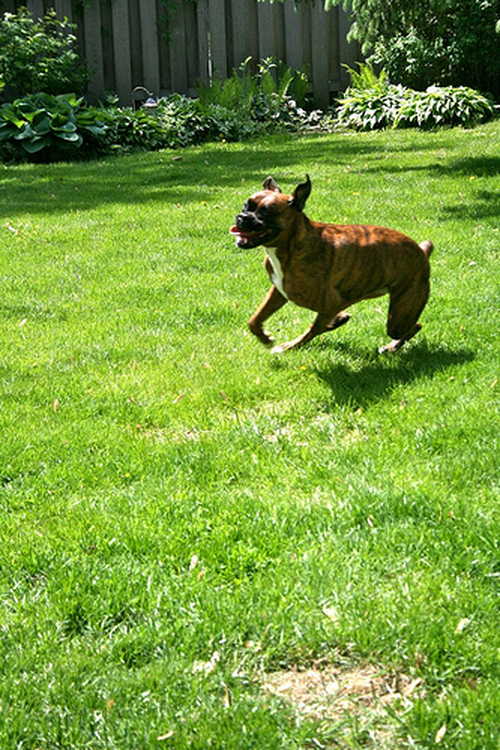

Description
0                  brown dog run on grass
1           dog run in fenced in backyard
2             dog run on sunny green lawn
3    dog run through the grass in the sun
4  young boxer dog race across green lawn

Predicted description         Score
0       tan dog be run on the grass  0.0383676846
1     tan dog run through the grass  0.0533208315
2  tan dog be run through the grass  0.0612168796

In [24]:
inspector.inspect(random_sample(test_samples))

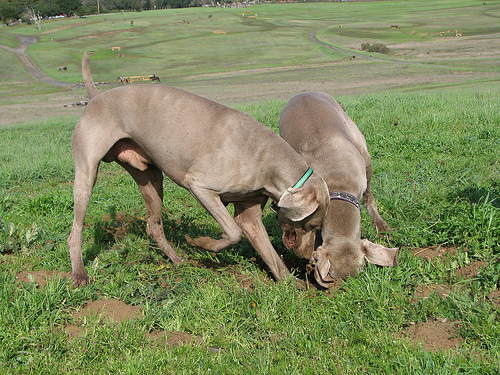

Description
0                     two brown dog sniff in the grass
1                 two brown dog wrestle on grassy hill
2                            two dog play in the grass
3  two greyishbrown dog look at something in the grass
4                              two weimeraner in field

Predicted description         Score
0         large brown dog play in the grass  0.0117709438
1  large brown dog be run through the grass  0.0428893140
2      large brown dog be play in the grass  0.0463116755

In [25]:
inspector.inspect(random_sample(test_samples))

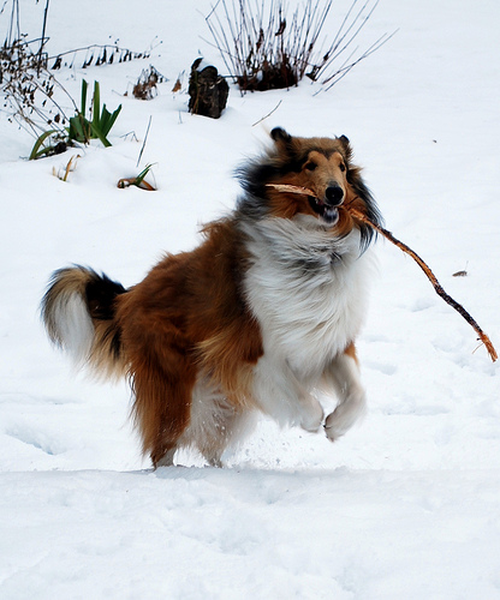

Description
0             dog carry stick in its mouth run through snowcovered field
1                   dog run over the snow carry large stick in its mouth
2                       dog run through the snow with stick in its mouth
3                                    fluffy dog carry stick through snow
4  large brown and white dog be carry stick through white and snowy area

Predicted description         Score
0      black and white dog be play in the snow  0.0000064999
1  black and white dog be run through the snow  0.0000090932
2     black and white dog run through the snow  0.0000157878

In [26]:
inspector.inspect(random_sample(test_samples))

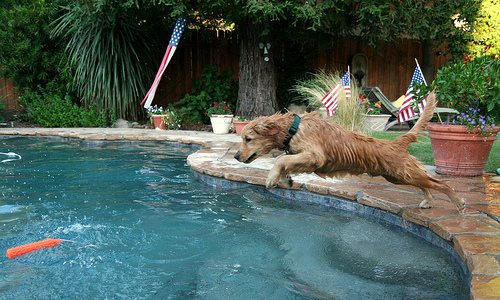

Description
0                            brown dog be leap into garden swim pool
1                                      brown dog leap into swim pool
2                 brown fluffy dog jump into swim pool after red toy
3                                  dog jump into swim pool after toy
4  dog take leap of faith as he jump into pool to grab an orange toy

Predicted description         Score
0      brown dog jump into swim pool  0.0001070393
1  brown dog jump into swim pool  to  0.0002209852
2  brown dog jump into swim pool  of  0.0002690965

In [27]:
inspector.inspect(random_sample(test_samples))

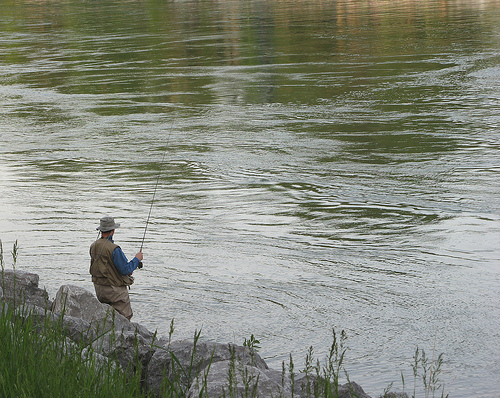

Description
0                            man fly fish in large river
1  man stand on the edge of the water and hold fish pole
2     man with tan hat and jacket be fish in green water
3   one lone fisherman with his line cast out into river
4                          man be fish at the water edge

Predicted description         Score
0  person stand on the edge of body of water on beach  0.0000027207
1           person stand on the edge of body of water  0.0000030390
2   person stand on the edge of body of water  in the  0.0000143871

In [29]:
inspector.inspect(random_sample(test_samples))